## <b>4.5 VALIDACIÓ, AVALUACIÓ I CONTROL DE QUALITAT</b>

Dades carregades OK
Freq shapes: (69740, 39) (35815, 39)
Sev shapes: (16259, 30) (3387, 30)
Ratio shapes: (69740, 19) (35815, 19)
[LightGBM] [Info] Number of positive: 16259, number of negative: 53481
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4730
[LightGBM] [Info] Number of data points in the train set: 69740, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.233137 -> initscore=-1.190680
[LightGBM] [Info] Start training from score -1.190680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4417
[LightGBM] [Info] Number of data points in the train set: 16259, number of used features: 27
[LightGBM] [Info] Start training from score 854.327142
[LightGBM] [Warning] No further 

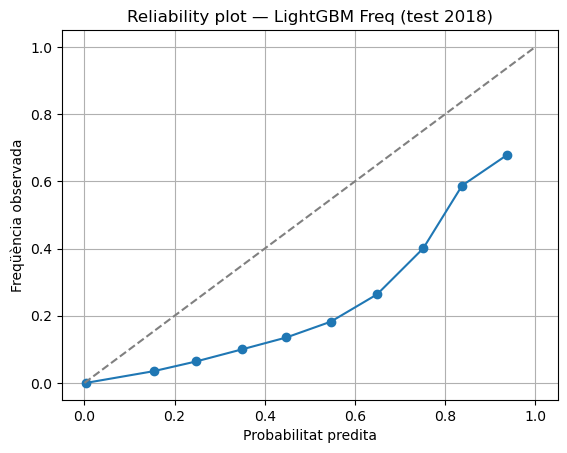


Fitxers guardats correctament.


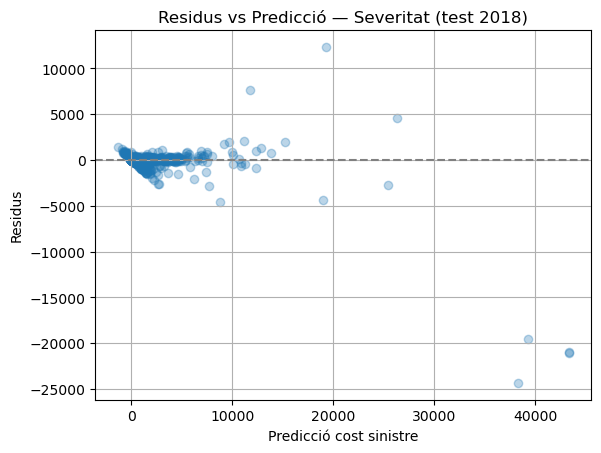


=== 4.5 COMPLETAT CORRECTAMENT ===


In [1]:
# ==========================================================
# 3.5 VALIDACIÓ, AVALUACIÓ I CONTROL DE QUALITAT
# ==========================================================
# Objectiu:
#   - Valido els models champion que m'he quedat com a finals:
#        * LightGBMClassifier (freqüència)
#        * LightGBMRegressor (severitat)
#   - Avaluo el rendiment real sobre el cohort temporal 2018 (test OOT).
#   - Miro dues coses clau de qualitat:
#        * calibratge de probabilitats (freq)
#        * residus i comportament d'errors (sev)
#
# Idea general:
#   - Aquí no faig tuning ni selecciono res: només confirmo que el que he triat
#     funciona bé fora del període d'entrenament.
# ==========================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier, LGBMRegressor

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    log_loss,
    brier_score_loss,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    f1_score,
)
from sklearn.calibration import calibration_curve


# ==========================================================
# 0) FUNCIONS AUXILIARS (mateixa lògica que he usat en modelatge)
# ==========================================================
# En aquesta secció defineixo funcions de preparació i alineació perquè:
#   - pugui reproduir exactament les mateixes exclusions (anti-leakage),
#   - i tingui train/test amb el mateix esquema de columnes.
#
# M'interessa que això sigui coherent amb 3.4.3 / 3.4.5, perquè si no,
# em podria sortir una validació "optimista" per un simple canvi de variables.

def prepare_xy_class_freq(df: pd.DataFrame, target: str = "Has_claims_year"):
    """
    PREPARACIÓ FREQÜÈNCIA (CLASSIFICACIÓ)
    - Excloc target i metadades (ID, Policy_year, set_type).
    - Ho faig així perquè aquestes columnes no poden entrar al model i,
      a més, em podria contaminar la validació (leakage temporal o d'identificació).
    """
    if target not in df.columns:
        raise ValueError(f"Falta la columna target '{target}' al dataset de freqüència.")

    exclude = [
        target,
        "ID",
        "Policy_year",
        "set_type",
    ]
    # Per robustesa: si algun dia algun fitxer no porta una columna, no em vull encallar
    exclude = [c for c in exclude if c in df.columns]

    X = df.drop(columns=exclude)
    y = df[target].astype(int)
    return X, y


def prepare_xy_severity(df: pd.DataFrame, target: str = "Cost_claims_year"):
    """
    PREPARACIÓ SEVERITAT (REGRESSIÓ)
    - Em quedo només amb sinistres amb cost positiu (target > 0).
    - Excloc també transformacions del target (log/cap) perquè no vull que el model
      "vegï" informació derivada directament del que intento predir.
    """
    if target not in df.columns:
        raise ValueError(f"Falta la columna target '{target}' al dataset de severitat.")

    # Treballo només amb sinistres amb cost (per coherència amb el model de severitat)
    df = df[df[target] > 0].copy()

    exclude = [
        target,
        "ID",
        "Policy_year",
        "set_type",
        "Cost_claims_year_log",
        "Cost_claims_year_cap",
    ]
    exclude = [c for c in exclude if c in df.columns]

    X = df.drop(columns=exclude)
    y = df[target]

    # Neteja mínima per evitar problemes numèrics (NaN/Inf) i valors estranys
    y = y.replace([np.inf, -np.inf], np.nan).fillna(y.median())
    y = y.clip(lower=1e-6)

    return X, y


def prepare_xy_ratio(df: pd.DataFrame, target: str = "Claims_to_premium_ratio"):
    """
    PREPARACIÓ RÀTIO ECONÒMICA (BENCHMARK)
    - Ho mantinc amb la mateixa filosofia: excloc metadades i deixo només predictors.
    - Aquí també faig una neteja bàsica de NaN/Inf perquè és una variable que pot explotar
      si hi ha divisions o valors extrems.
    """
    if target not in df.columns:
        raise ValueError(f"Falta la columna '{target}' al dataset de ràtio.")

    exclude = [
        target,
        "ID",
        "Policy_year",
        "set_type",
    ]
    exclude = [c for c in exclude if c in df.columns]

    X = df.drop(columns=exclude)
    y = df[target]

    X = X.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    y = y.replace([np.inf, -np.inf], np.nan).fillna(y.median())

    return X, y


def align_train_test(X_train: pd.DataFrame, X_test: pd.DataFrame):
    """
    ALINEACIÓ ROBUSTA TRAIN/TEST
    - Em quedo només amb variables numèriques (per evitar problemes si hi ha object/cat).
    - Forço que el test tingui exactament les mateixes columnes que el train.
    - Converteixo NaN/Inf a 0.0 (és una decisió pràctica per no trencar el model en validació).
    """
    X_train_num = X_train.select_dtypes(include=[np.number]).copy()
    X_test_num  = X_test.select_dtypes(include=[np.number]).copy()

    # Agafo el "schema" del train i reindexo el test perquè quedi idèntic
    train_cols = X_train_num.columns.tolist()
    X_test_num = X_test_num.reindex(columns=train_cols, fill_value=0.0)

    # Neteja final (per si hi ha ratios o valors infinits)
    X_train_num = X_train_num.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    X_test_num  = X_test_num.replace([np.inf, -np.inf], np.nan).fillna(0.0)

    return X_train_num, X_test_num


# ==========================================================
# 1) CÀRREGA DE DADES
# ==========================================================
# Carrego els datasets del pipeline ja processats:
#   - freq_gbm_* per la freqüència (full engineered)
#   - sev_* per severitat
#   - ratio_* si vull tenir el benchmark de ràtio (tot i que aquí el foco és champion)
MODEL_PATH = "data/model"
np.random.seed(42)

freq_train  = pd.read_csv(os.path.join(MODEL_PATH, "freq_gbm_train.csv"))
freq_test   = pd.read_csv(os.path.join(MODEL_PATH, "freq_gbm_test.csv"))
sev_train   = pd.read_csv(os.path.join(MODEL_PATH, "sev_train.csv"))
sev_test    = pd.read_csv(os.path.join(MODEL_PATH, "sev_test.csv"))
ratio_train = pd.read_csv(os.path.join(MODEL_PATH, "ratio_train.csv"))
ratio_test  = pd.read_csv(os.path.join(MODEL_PATH, "ratio_test.csv"))

print("Dades carregades OK")


# ==========================================================
# 2) PREPARACIÓ X, y (mateixa lògica que en modelatge)
# ==========================================================

# --- FREQÜÈNCIA ---
X_train_freq_raw, y_train_freq = prepare_xy_class_freq(freq_train, target="Has_claims_year")
X_test_freq_raw,  y_test_freq  = prepare_xy_class_freq(freq_test,  target="Has_claims_year")

# Alineo columnes i netejo NaN/Inf
X_train_freq, X_test_freq = align_train_test(X_train_freq_raw, X_test_freq_raw)
print("Freq shapes:", X_train_freq.shape, X_test_freq.shape)

# --- SEVERITAT ---
X_train_sev_raw, y_train_sev = prepare_xy_severity(sev_train, target="Cost_claims_year")
X_test_sev_raw,  y_test_sev  = prepare_xy_severity(sev_test,  target="Cost_claims_year")

X_train_sev, X_test_sev = align_train_test(X_train_sev_raw, X_test_sev_raw)
print("Sev shapes:", X_train_sev.shape, X_test_sev.shape)

# --- RÀTIO (benchmark) ---
# Encara que aquí el focus és el champion de freq/sev, em deixo preparat el benchmark de ràtio.
X_train_ratio_raw, y_train_ratio = prepare_xy_ratio(ratio_train, target="Claims_to_premium_ratio")
X_test_ratio_raw,  y_test_ratio  = prepare_xy_ratio(ratio_test,  target="Claims_to_premium_ratio")

X_train_ratio, X_test_ratio = align_train_test(X_train_ratio_raw, X_test_ratio_raw)
print("Ratio shapes:", X_train_ratio.shape, X_test_ratio.shape)


# ==========================================================
# 3) ENTRENAMENT MODELS CHAMPION (mateixos hiperparàmetres)
# ==========================================================
# Torno a entrenar els champions sobre train 2015–2017 amb els mateixos hiperparàmetres.
# Això em permet calcular mètriques sobre el test 2018 sense fer cap "toc" extra.

# 3.1 Champion FREQ (LightGBMClassifier)
lgbm_clf = LGBMClassifier(
    n_estimators=600,
    learning_rate=0.02,
    max_depth=-1,
    num_leaves=63,
    subsample=1.0,
    colsample_bytree=0.8,
    objective="binary",
    random_state=42,
    n_jobs=-1,
)
lgbm_clf.fit(X_train_freq, y_train_freq)

# Em quedo amb probabilitats (necessàries per AUC, PR-AUC, logloss i calibratge)
freq_proba = np.clip(lgbm_clf.predict_proba(X_test_freq)[:, 1], 1e-15, 1 - 1e-15)

# 3.2 Champion SEV (LightGBMRegressor)
lgbm_reg = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.02,
    max_depth=5,
    num_leaves=127,
    subsample=0.7,
    colsample_bytree=0.7,
    objective="regression",
    random_state=42,
    n_jobs=-1,
)
lgbm_reg.fit(X_train_sev, y_train_sev)

sev_pred = lgbm_reg.predict(X_test_sev)


# ==========================================================
# 4) VALIDACIÓ EXTERNA — MÈTRIQUES FINALS (test 2018)
# ==========================================================
# Aquí és on realment comprovo el rendiment OOT (out-of-time).
# És la part que m'interessa per defensar que el model generalitza.

print("\n=== VALIDACIÓ EXTERNA — FREQÜÈNCIA (test 2018) ===")
print("AUC       :", roc_auc_score(y_test_freq, freq_proba))
print("PR-AUC    :", average_precision_score(y_test_freq, freq_proba))
print("LogLoss   :", log_loss(y_test_freq, freq_proba))
print("Brier     :", brier_score_loss(y_test_freq, freq_proba))
print("F1 (0.5)  :", f1_score(y_test_freq, (freq_proba >= 0.5).astype(int)))

print("\n=== VALIDACIÓ EXTERNA — SEVERITAT (test 2018, cost>0) ===")
print("MAE       :", mean_absolute_error(y_test_sev, sev_pred))
print("RMSE      :", np.sqrt(mean_squared_error(y_test_sev, sev_pred)))
print("R²        :", r2_score(y_test_sev, sev_pred))


# ==========================================================
# 5) CALIBRATGE (FREQÜÈNCIA) — Reliability plot
# ==========================================================
# Aquí miro si les probabilitats que surtin del model són "creïbles".
# Un model pot tenir bona AUC però estar mal calibrat (probabilitats massa altes o baixes).
prob_true, prob_pred = calibration_curve(y_test_freq, freq_proba, n_bins=10)

plt.figure()
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.title("Reliability plot — LightGBM Freq (test 2018)")
plt.xlabel("Probabilitat predita")
plt.ylabel("Freqüència observada")
plt.grid(True)
plt.show()


# ==========================================================
# 6) GUARDAR MÈTRIQUES FINALS DELS CHAMPIONS
# ==========================================================
# Ho guardo a CSV perquè després pugui:
#   - afegir-ho a taules del TFM
#   - reutilitzar-ho en scripts sense recalcular
pd.DataFrame([{
    "model": "LightGBMClassifier",
    "test_auc": roc_auc_score(y_test_freq, freq_proba),
    "test_pr_auc": average_precision_score(y_test_freq, freq_proba),
    "test_logloss": log_loss(y_test_freq, freq_proba),
    "test_brier": brier_score_loss(y_test_freq, freq_proba),
    "test_f1_0_5": f1_score(y_test_freq, (freq_proba >= 0.5).astype(int)),
}]).to_csv(os.path.join(MODEL_PATH, "champion_freq_metrics.csv"), index=False)

pd.DataFrame([{
    "model": "LightGBMRegressor",
    "test_mae": mean_absolute_error(y_test_sev, sev_pred),
    "test_rmse": np.sqrt(mean_squared_error(y_test_sev, sev_pred)),
    "test_r2": r2_score(y_test_sev, sev_pred),
}]).to_csv(os.path.join(MODEL_PATH, "champion_sev_metrics.csv"), index=False)

print("\nFitxers guardats correctament.")


# ==========================================================
# 7) DIAGNÒSTIC DE RESIDUS (SEVERITAT)
# ==========================================================
# Aquí miro si hi ha patrons estranys als errors:
#   - si els residus creixen amb la predicció (heteroscedasticitat),
#   - si hi ha outliers brutals,
#   - o si hi ha zones on el model sistemàticament infra/sobreestima.
residuals = y_test_sev - sev_pred

plt.figure()
plt.scatter(sev_pred, residuals, alpha=0.3)
plt.axhline(0, linestyle="--", color="gray")
plt.xlabel("Predicció cost sinistre")
plt.ylabel("Residus")
plt.title("Residus vs Predicció — Severitat (test 2018)")
plt.grid(True)
plt.show()

print("\n=== 3.5 COMPLETAT CORRECTAMENT ===")


## <b>3.6 RESULTATS OBTINGUTS</b>

freq_model_comparison: (6, 6)
sev_model_comparison : (2, 4)
ratio_model_comparison: (1, 4)
champion_freq_metrics: (1, 6)
champion_sev_metrics : (1, 4)

Taula 3.6.1 (freqüència) guardada a: data/model\table_3_6_1_freq_metrics.csv
Taula 3.6.1 (severitat) guardada a: data/model\table_3_6_1_sev_metrics.csv
Taula 3.6.1 (ràtio) guardada a: data/model\table_3_6_1_ratio_metrics.csv

Figura 3.6.1 guardada a: data/model\fig_3_6_1_freq_AUC_F1.png


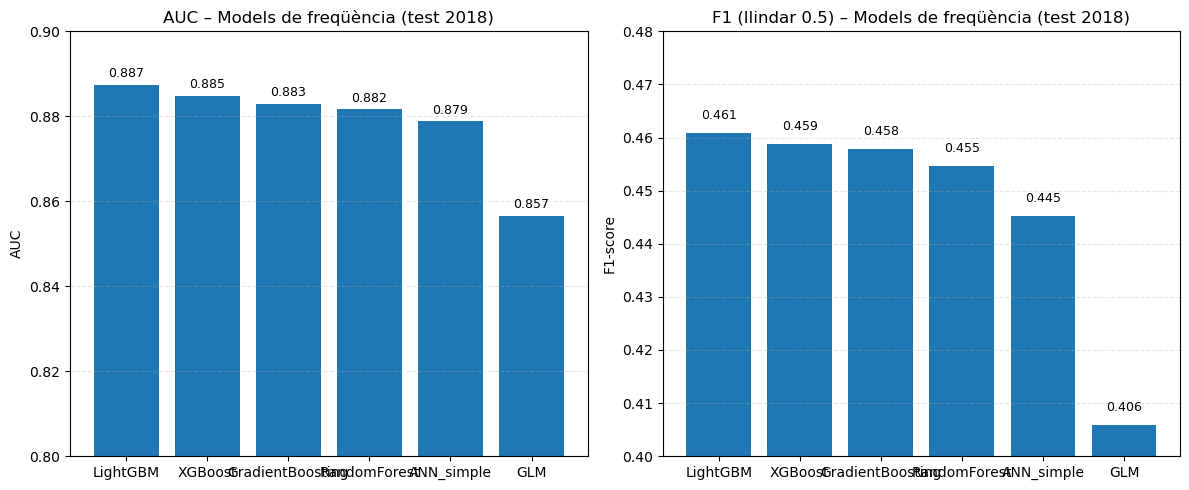

Figura 3.6.2 guardada a: data/model\fig_3_6_2_sev_MAE_RMSE_R2.png


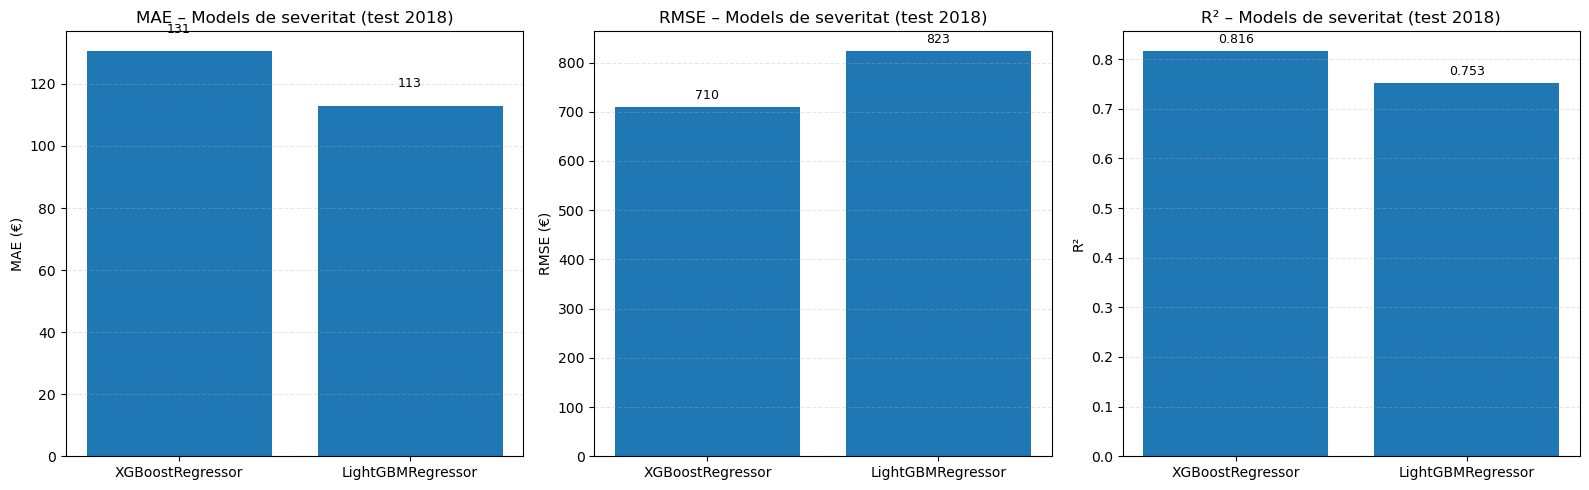


Taula 3.6.6 (resum final de models champion) guardada a: data/model\table_3_6_6_final_champions.csv

Contingut de la taula 3.6.6:
       target      model_champion metric_1  metric_1_value metric_2  \
0  Freqüència  LightGBMClassifier      AUC        0.887446   PR-AUC   
1   Severitat   LightGBMRegressor      MAE      112.985614     RMSE   

   metric_2_value metric_3  metric_3_value  metric_4  metric_4_value  
0        0.452362    Brier        0.105223  F1 (0.5)        0.460871  
1      823.222488       R²        0.752777                       NaN  

=== 3.6 RESULTATS OBTINGUTS – CODI COMPLETAT ===


In [4]:
# ==========================================================
# 3.6 RESULTATS OBTINGUTS
# ==========================================================
# Objectius d'aquest bloc:
#   - Carrego les taules de comparació de models (freq, sev i ràtio).
#   - Carrego les mètriques finals dels models champion:
#       * LightGBMClassifier per a freqüència
#       * LightGBMRegressor per a severitat
#   - A partir d'això, genero:
#       * Taules de mètriques finals (3.6.1)
#       * Figures comparatives (3.6.2)
#       * Taula consolidada final de models champion (3.6.6)
#
# Fitxers que espero trobar dins de data/model/:
#   - freq_model_comparison.csv
#   - sev_model_comparison.csv
#   - ratio_model_comparison.csv
#   - champion_freq_metrics.csv
#   - champion_sev_metrics.csv
#   - freq_shap_importance.csv (opcional, si he generat XAI)
#   - sev_shap_importance.csv  (opcional, si he generat XAI)
#
# Nota:
#   - Aquesta secció està pensada perquè després pugui copiar taules/figures
#     directament al redactat del TFM (Word o LaTeX).
# ==========================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Per coherència amb la resta del projecte (i per evitar errors si la carpeta no existeix)
MODEL_PATH = "data/model"
os.makedirs(MODEL_PATH, exist_ok=True)


# ----------------------------------------------------------
# 1) CÀRREGA DE TAULES I MÈTRIQUES CHAMPION
# ----------------------------------------------------------
# Aquí només carrego els CSV que s'han anat guardant a les seccions anteriors.
# Si algun fitxer no hi és, prefereixo que peti aquí i no més endavant.
freq_comp_path   = os.path.join(MODEL_PATH, "freq_model_comparison.csv")
sev_comp_path    = os.path.join(MODEL_PATH, "sev_model_comparison.csv")
ratio_comp_path  = os.path.join(MODEL_PATH, "ratio_model_comparison.csv")
champ_freq_path  = os.path.join(MODEL_PATH, "champion_freq_metrics.csv")
champ_sev_path   = os.path.join(MODEL_PATH, "champion_sev_metrics.csv")

freq_comp  = pd.read_csv(freq_comp_path)
sev_comp   = pd.read_csv(sev_comp_path)
ratio_comp = pd.read_csv(ratio_comp_path)

champ_freq = pd.read_csv(champ_freq_path)
champ_sev  = pd.read_csv(champ_sev_path)

# Deixo un rastre ràpid de dimensions per assegurar-me que he carregat el que tocava
print("freq_model_comparison:", freq_comp.shape)
print("sev_model_comparison :", sev_comp.shape)
print("ratio_model_comparison:", ratio_comp.shape)
print("champion_freq_metrics:", champ_freq.shape)
print("champion_sev_metrics :", champ_sev.shape)


# ----------------------------------------------------------
# 2) 3.6.1 TAULES DE MÈTRIQUES FINALS
# ----------------------------------------------------------
# En aquesta part faig taules "netes" exportables per al TFM.
# Bàsicament és agafar el que ja he calculat i guardar-ho amb un nom de fitxer
# que em sigui fàcil de referenciar al document.

# 2.1 Taula completa de models de freqüència (test 2018)
freq_metrics_table = freq_comp.copy()
freq_metrics_table_path = os.path.join(MODEL_PATH, "table_3_6_1_freq_metrics.csv")
freq_metrics_table.to_csv(freq_metrics_table_path, index=False)
print(f"\nTaula 3.6.1 (freqüència) guardada a: {freq_metrics_table_path}")

# 2.2 Taula completa de models de severitat (test 2018)
sev_metrics_table = sev_comp.copy()
sev_metrics_table_path = os.path.join(MODEL_PATH, "table_3_6_1_sev_metrics.csv")
sev_metrics_table.to_csv(sev_metrics_table_path, index=False)
print(f"Taula 3.6.1 (severitat) guardada a: {sev_metrics_table_path}")

# 2.3 Taula de model directe de ràtio (benchmark)
# Aquesta taula és simple perquè aquí només hi ha el model benchmark directe.
ratio_metrics_table = ratio_comp.copy()
ratio_metrics_table_path = os.path.join(MODEL_PATH, "table_3_6_1_ratio_metrics.csv")
ratio_metrics_table.to_csv(ratio_metrics_table_path, index=False)
print(f"Taula 3.6.1 (ràtio) guardada a: {ratio_metrics_table_path}")


# ----------------------------------------------------------
# 3) 3.6.2 FIGURES COMPARATIVES
# ----------------------------------------------------------
# Aquí genero figures per comparar visualment:
#   - Models de freqüència: AUC i F1 (llindar 0.5)
#   - Models de severitat: MAE, RMSE i R²
#
# Detall:
#   - Les escales (ylim) les fixo perquè en el meu cas els valors estan en rangs
#     relativament estrets. Si algun model surt fora, ho ajusto i ja està.

# 3.1 Figura 3.6.1 – Models de FREQÜÈNCIA (AUC i F1)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

models_freq = freq_comp["model"]
auc_values  = freq_comp["test_auc"]
f1_values   = freq_comp["test_f1_0_5"]

# --- Subfigura esquerra: AUC ---
ax = axes[0]
bars_auc = ax.bar(models_freq, auc_values)
ax.set_title("AUC – Models de freqüència (test 2018)")
ax.set_ylabel("AUC")
ax.set_ylim(0.80, 0.90)
ax.grid(axis="y", linestyle="--", alpha=0.3)

# Escric el valor sobre cada barra perquè després pugui exportar la figura al TFM sense haver de mirar la taula
for bar, val in zip(bars_auc, auc_values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        val + 0.001,
        f"{val:.3f}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

# --- Subfigura dreta: F1(0.5) ---
ax = axes[1]
bars_f1 = ax.bar(models_freq, f1_values)
ax.set_title("F1 (llindar 0.5) – Models de freqüència (test 2018)")
ax.set_ylabel("F1-score")
ax.set_ylim(0.40, 0.48)
ax.grid(axis="y", linestyle="--", alpha=0.3)

for bar, val in zip(bars_f1, f1_values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        val + 0.002,
        f"{val:.3f}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.tight_layout()
fig_freq_path = os.path.join(MODEL_PATH, "fig_3_6_1_freq_AUC_F1.png")
plt.savefig(fig_freq_path, dpi=300, bbox_inches="tight")
print(f"\nFigura 3.6.1 guardada a: {fig_freq_path}")
plt.show()


# 3.2 Figura 3.6.2 – Models de SEVERITAT (MAE, RMSE, R²)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

models_sev  = sev_comp["model"]
mae_values  = sev_comp["test_mae"]
rmse_values = sev_comp["test_rmse"]
r2_values   = sev_comp["test_r2"]

# --- Subfigura 1: MAE ---
ax = axes[0]
bars_mae = ax.bar(models_sev, mae_values)
ax.set_title("MAE – Models de severitat (test 2018)")
ax.set_ylabel("MAE (€)")
ax.grid(axis="y", linestyle="--", alpha=0.3)

for bar, val in zip(bars_mae, mae_values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        val + 5,
        f"{val:.0f}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

# --- Subfigura 2: RMSE ---
ax = axes[1]
bars_rmse = ax.bar(models_sev, rmse_values)
ax.set_title("RMSE – Models de severitat (test 2018)")
ax.set_ylabel("RMSE (€)")
ax.grid(axis="y", linestyle="--", alpha=0.3)

for bar, val in zip(bars_rmse, rmse_values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        val + 10,
        f"{val:.0f}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

# --- Subfigura 3: R² ---
ax = axes[2]
bars_r2 = ax.bar(models_sev, r2_values)
ax.set_title("R² – Models de severitat (test 2018)")
ax.set_ylabel("R²")
ax.grid(axis="y", linestyle="--", alpha=0.3)

for bar, val in zip(bars_r2, r2_values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        val + 0.01,
        f"{val:.3f}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.tight_layout()
fig_sev_path = os.path.join(MODEL_PATH, "fig_3_6_2_sev_MAE_RMSE_R2.png")
plt.savefig(fig_sev_path, dpi=300, bbox_inches="tight")
print(f"Figura 3.6.2 guardada a: {fig_sev_path}")
plt.show()


# ----------------------------------------------------------
# 4) 3.6.6 TAULA CONSOLIDADA FINAL (MODELS CHAMPION)
# ----------------------------------------------------------
# Aquí construeixo una taula resum amb només els models finals ("champions"):
#   - Freqüència: LightGBMClassifier
#   - Severitat : LightGBMRegressor
#
# La idea és que aquesta taula sigui una mena de "resum executiu"
# amb les mètriques clau que després vull destacar al TFM.

# M'asseguro que cada fitxer champion tingui exactament una fila (hauria de ser així)
assert len(champ_freq) == 1, "champion_freq_metrics hauria de tenir una sola fila"
assert len(champ_sev) == 1, "champion_sev_metrics hauria de tenir una sola fila"

row_freq = champ_freq.iloc[0]
row_sev  = champ_sev.iloc[0]

final_rows = [
    {
        "target": "Freqüència",
        "model_champion": row_freq["model"],
        "metric_1": "AUC",
        "metric_1_value": row_freq["test_auc"],
        "metric_2": "PR-AUC",
        "metric_2_value": row_freq["test_pr_auc"],
        "metric_3": "Brier",
        "metric_3_value": row_freq["test_brier"],
        "metric_4": "F1 (0.5)",
        "metric_4_value": row_freq["test_f1_0_5"],
    },
    {
        "target": "Severitat",
        "model_champion": row_sev["model"],
        "metric_1": "MAE",
        "metric_1_value": row_sev["test_mae"],
        "metric_2": "RMSE",
        "metric_2_value": row_sev["test_rmse"],
        "metric_3": "R²",
        "metric_3_value": row_sev["test_r2"],
        "metric_4": "",
        "metric_4_value": np.nan,
    },
]

final_table = pd.DataFrame(final_rows)

final_consol_path = os.path.join(MODEL_PATH, "table_3_6_6_final_champions.csv")
final_table.to_csv(final_consol_path, index=False)

print(f"\nTaula 3.6.6 (resum final de models champion) guardada a: {final_consol_path}")
print("\nContingut de la taula 3.6.6:")
print(final_table)

print("\n=== 3.6 RESULTATS OBTINGUTS – CODI COMPLETAT ===")
